# Photo Classifier: Model training

## Imports and configuration

In [1]:
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
%load_ext autoreload
%autoreload 2
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib.pyplot as plt
from torchsummary import summary
import logging
import random
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
from scipy.signal import savgol_filter

In [3]:
from constants import *
from image_transforms import IMAGE_TRANSFORMS
from plotting import imshow_tensor, show_image
from data_loaders.image_loader_labels_from_folders import ImageLoader
from image_data import ImageData
from model import get_pretrained_model_for_transfer_learning
from file_io import save_pickle_file
from learners.utils import get_learner

In [4]:
random.seed(42)
logging.basicConfig(level=logging.INFO)

## Data loading and grouping to training, validation and test set

In [5]:
data_loader = ImageLoader()
data = data_loader.load_images_with_labels(SOURCE_DATA_PATH)

INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 1/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 2/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 3/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 4/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 5/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 6/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 7/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 8/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 9/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 10/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 11/136 images load

INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 91/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 92/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 93/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 94/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 95/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 96/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 97/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 98/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 99/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 100/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 101/136 

INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 43/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 44/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 45/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 46/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 47/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 48/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 49/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 50/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 51/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 52/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Gr

INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 130/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 131/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 132/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 133/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 134/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 135/135 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 1/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 2/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 3/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 4/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 

INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 85/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 86/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 87/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 88/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 89/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 90/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 91/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 92/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 93/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 94/114 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 95/114 images loaded

In [6]:
image_data = ImageData(data, P_TRAINING, P_VALID, P_TEST)

## Image preprocessing

In [7]:
@interact(index=widgets.IntSlider(min=0, max=10, step=1, value=0, continuous_update=False))
def show(index=0, data_set_name=['training', 'validation', 'test']):
    label = image_data.get_label(index, data_set_name)
    image = image_data.get_image(index, data_set_name)
    show_image(image, label)

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=10), Dropdown(descr…

In [8]:
test_image = image_data.get_image(0, 'training')
training_transforms = IMAGE_TRANSFORMS['training']

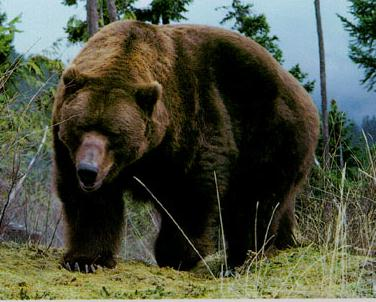

In [9]:
test_image

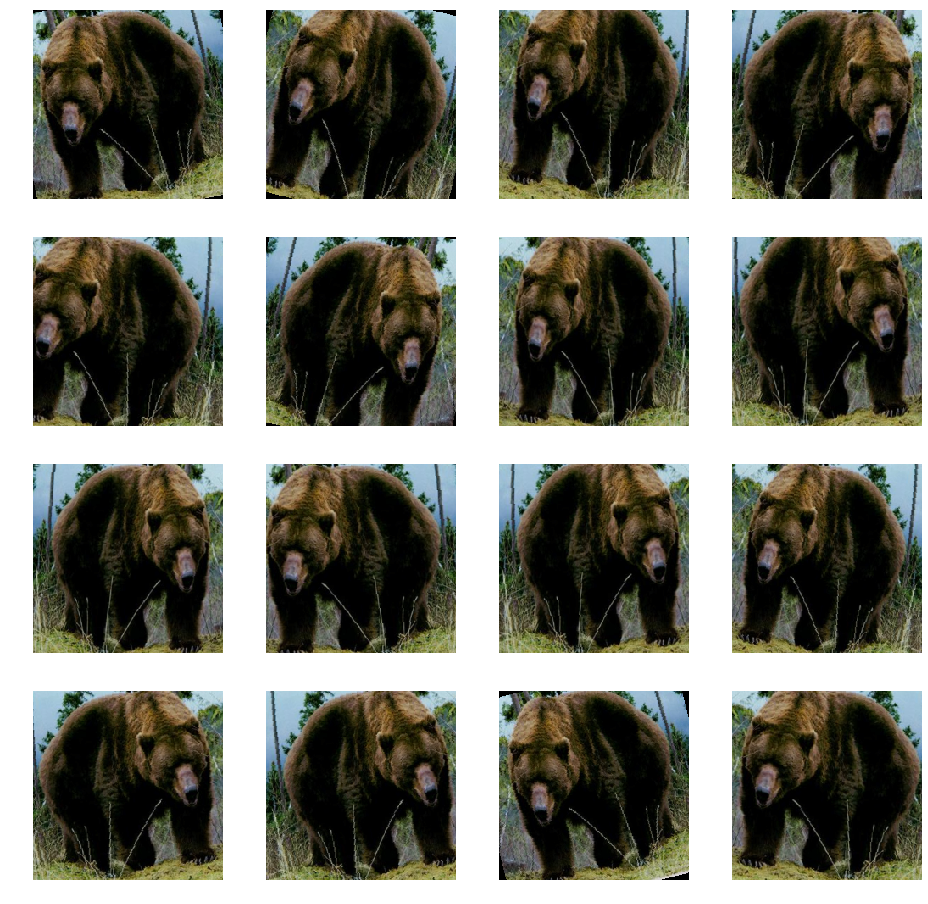

In [10]:
_ = plt.figure(figsize=(16,16))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    transformed_image = training_transforms(test_image)
    _ = imshow_tensor(transformed_image, ax=ax, mean=IMAGE_NET_MEAN, std=IMAGE_NET_STD)

## Model

In [11]:
n_classes = len(image_data.labels)
model = get_pretrained_model_for_transfer_learning(n_classes, IS_MULTILABEL_CLASSIFICATION, DROPOUT, MODEL_ARCHITECTURE)

In [12]:
summary(model, input_size=(3, 224, 224), batch_size=BATCH_SIZE, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [6, 64, 224, 224]           1,792
              ReLU-2          [6, 64, 224, 224]               0
            Conv2d-3          [6, 64, 224, 224]          36,928
              ReLU-4          [6, 64, 224, 224]               0
         MaxPool2d-5          [6, 64, 112, 112]               0
            Conv2d-6         [6, 128, 112, 112]          73,856
              ReLU-7         [6, 128, 112, 112]               0
            Conv2d-8         [6, 128, 112, 112]         147,584
              ReLU-9         [6, 128, 112, 112]               0
        MaxPool2d-10           [6, 128, 56, 56]               0
           Conv2d-11           [6, 256, 56, 56]         295,168
             ReLU-12           [6, 256, 56, 56]               0
           Conv2d-13           [6, 256, 56, 56]         590,080
             ReLU-14           [6, 256,

## Model training

In [13]:
Learner = get_learner(IS_MULTILABEL_CLASSIFICATION)
learner = Learner(model)
losses, losses_valid = learner.fit_model(image_data,
                                        image_transforms_training=IMAGE_TRANSFORMS['training'],
                                        image_transforms_validation=IMAGE_TRANSFORMS['validation'],
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        weight_decay=WEIGHT_DECAY,
                                        early_stop_option=USE_EARLY_STOP)

INFO:learners.base_learner:
            Epoch: 1/15
            Validation loss: 0.13664264976978302
INFO:learners.base_learner:
            Epoch: 2/15
            Validation loss: 0.11511559039354324
INFO:learners.base_learner:
            Epoch: 3/15
            Validation loss: 0.1346828192472458
INFO:learners.base_learner:
            Epoch: 4/15
            Validation loss: 0.1546216905117035
INFO:learners.base_learner:Early stop criterion filled; fitting completed!
INFO:learners.base_learner:Lowest validation loss: epoch 2; loss 0.11511559039354324


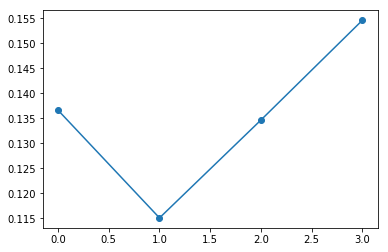

In [14]:
_ = plt.plot(losses_valid, '-o')

In [15]:
def round_up_to_odd(f):
    return int(np.ceil(f) // 2 * 2 + 1)

window_size = round_up_to_odd(len(losses)/4)
smoothed_losses = savgol_filter(losses, window_size, 2)

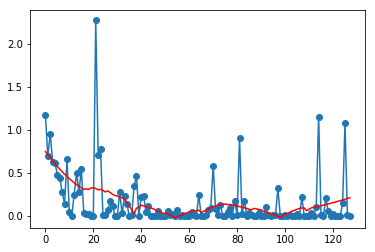

In [16]:
_ = plt.plot(losses, '-o')
_ = plt.plot(smoothed_losses, 'r-')

## Save data and model

In [17]:
save_pickle_file(learner, MODEL_FILE_PATH)
save_pickle_file(image_data, IMAGE_DATA_PATH)